# Create Graphics as Illustration in Text

In this notebook, we want to design a pipeline that create images that related to the corresponding text. Let's start with some text-to-image models.

The OpenAI's [DALL·E](https://openai.com/blog/dall-e/) is one of the most famous text-to-image models, which can take a descriptive sentence as the input and then create an image accordingly. The original DALLE is a huge model, and there is a smaller version, [dalle-mini](https://huggingface.co/flax-community/dalle-mini), available in Higging Face model hub.

Another popular image generator model is [BigGan](https://arxiv.org/abs/1809.11096), a comprehensive introduction (in zh-TW) can be found [here](https://xiaosean5408.medium.com/biggan%E7%B0%A1%E4%BB%8B-large-scale-gan-training-for-high-fidelity-natural-image-synthesis-df349a5f811c). The **BigGan** takes ImgNet text as its input and generates images in the corresponding category. The implementations in various resolutions can be found in both HiggingFace and TensorFlow hub.


## Text to Image Models
- [Hugging Face Repo](https://huggingface.co/models?pipeline_tag=text-to-image&sort=downloads)
    + [dalle-mini](https://huggingface.co/flax-community/dalle-mini)
    + [BigGan](https://huggingface.co/osanseviero/BigGAN-deep-128)
- [TensorFlow Hub](https://tfhub.dev/s?module-type=image-generator)
    + [biggan-deep-512](https://tfhub.dev/deepmind/biggan-deep-512/1)
    + [bigbigan-resnet50](https://tfhub.dev/deepmind/bigbigan-resnet50/1)


## Our Approach
Our goal is to generate images that can support the generated text, such as illustrations in a book of essays and poems. As a result, we may not need images represent exactly described in the text, but images some what related to the text along side. Hence, we can use smaller model to generate the images, and then post-process the outputs to retain relations to the corresponding text.


## [bigbigan-resnet50](https://tfhub.dev/deepmind/bigbigan-resnet50/1)

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

model_url = 'https://tfhub.dev/deepmind/bigbigan-resnet50/1'
local_model_url = 'D:/workspace/image_generation_models/biggan-resnet50/'

# Load model from TF-hub and save to local (only execute once)
#model = hub.load(model_url)
#tf.saved_model.save(model, local_model_url, signatures=model.signatures)
#print(model.signatures.keys())

C:\Users\tsyo\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\tsyo\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\tsyo\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
  stacklevel=1)


INFO:tensorflow:Assets written to: D:/workspace/image_generation_models/biggan-resnet50/assets


INFO:tensorflow:Assets written to: D:/workspace/image_generation_models/biggan-resnet50/assets


KeysView(_SignatureMap({'default': <ConcreteFunction pruned(x) at 0x21DF9FF4148>, 'discriminate': <ConcreteFunction pruned(x, z) at 0x21DFE1A2908>, 'generate': <ConcreteFunction pruned(z) at 0x21F8FAF5D08>, 'encode': <ConcreteFunction pruned(x) at 0x21F9E4C0D48>}))


In [1]:
import tensorflow as tf
import tensorflow_hub as hub

model_url = 'https://tfhub.dev/deepmind/bigbigan-resnet50/1'
local_model_url = 'D:/workspace/image_generation_models/biggan-resnet50/'

model = tf.saved_model.load(local_model_url)
print(model)
print(model.signatures.keys())

C:\Users\tsyo\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\tsyo\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\tsyo\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
  stacklevel=1)


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x00000142808BEC88>
KeysView(_SignatureMap({'default': <ConcreteFunction signature_wrapper(*, x) at 0x1427F428BC8>, 'discriminate': <ConcreteFunction signature_wrapper(*, x, z) at 0x14249C1B508>, 'generate': <ConcreteFunction signature_wrapper(*, z) at 0x142497989C8>, 'encode': <ConcreteFunction signature_wrapper(*, x) at 0x142496D8288>}))


In [2]:
# Create some samples
z = tf.random.normal([8, 120])                # latent samples
gen_samples = model.signatures['generate'](z)

gen_samples.keys()

dict_keys(['upsampled', 'default'])

In [3]:
# Explore the generated image
print(gen_samples['default'].shape)
print(gen_samples['upsampled'].shape)

(8, 128, 128, 3)
(8, 256, 256, 3)


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

images = np.array(gen_samples['upsampled'])

np.histogram(images.flatten())

(array([ 46778, 245466, 274005, 316530, 254715, 191142, 113374,  66342,
         51347,  13165], dtype=int64),
 array([-1.1642534 , -0.9252216 , -0.6861899 , -0.4471582 , -0.20812647,
         0.03090525,  0.26993698,  0.5089687 ,  0.7480004 ,  0.9870321 ,
         1.2260638 ], dtype=float32))

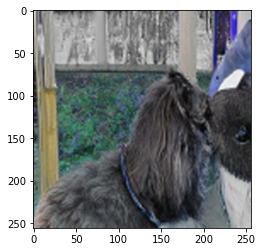

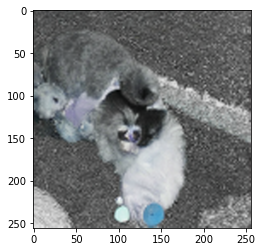

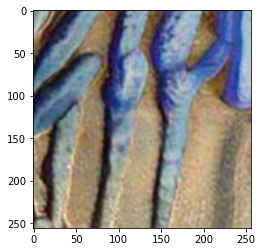

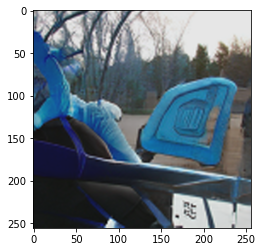

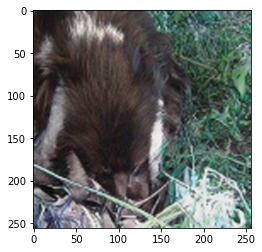

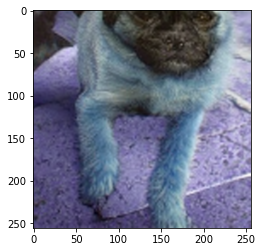

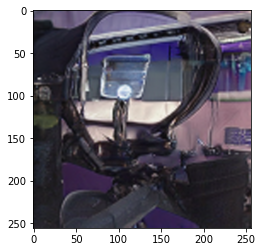

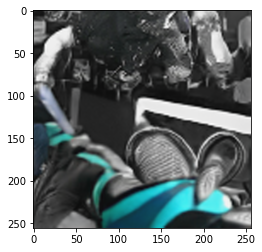

In [5]:
for i in range(images.shape[0]):
    tmp = np.flip(images[i,:,:,:],2)
    tmp = (tmp-np.min(tmp))/(np.max(tmp)-np.min(tmp))
    plt.imshow(tmp)
    plt.show()

## Sentences, Embeddings, to Images

Now, we are going to develop a method that project the generated poem (sentences) to a embedding, mapping the embedding to vectors of (,120), and then use the projected vectors to generate images.

In [4]:
# Sentence to embedding to images
from sentence_transformers import SentenceTransformer
#import tensorflow as tf

st = SentenceTransformer("D:/workspace/language_models/distiluse-base-multilingual-cased-v2/")
sentence = "應該是選擇那問題就來了，所以才能把問卷和結局形成一個結果，然後可以把最大的結論和輸入到很多事物上去，她每天的表現竟是她自己定做的，她一直想不到自以為他們都沒有在意"

se = st.encode(sentence)

print(se.shape)

import pickle

pickle.dump(se, open('../data/poem_embedding.pkl', 'wb'))

(512,)


## Conflict between SentenceTransformer and tf.saved_model

These two modules both use the same cuDNN dynamic library file, and cannot be executed in the same session. So we separate the process into two steps as a quick fix.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pickle

se = pickle.load(open('../data/poem_embedding.pkl', 'rb'))

local_model_url = 'D:/workspace/image_generation_models/biggan-resnet50/'
model = tf.saved_model.load(local_model_url)
print(model.signatures.keys())

z = tf.convert_to_tensor(np.array(se[:480]).reshape((4,120)))
print(z.shape)

C:\Users\tsyo\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\tsyo\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\tsyo\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
  stacklevel=1)


KeysView(_SignatureMap({'default': <ConcreteFunction signature_wrapper(*, x) at 0x1F94B218148>, 'discriminate': <ConcreteFunction signature_wrapper(*, x, z) at 0x1F9CAF90288>, 'generate': <ConcreteFunction signature_wrapper(*, z) at 0x1F9CAF8B2C8>, 'encode': <ConcreteFunction signature_wrapper(*, x) at 0x1F9CA60FD48>}))
(4, 120)


In [2]:
gen_samples = model.signatures['generate'](z)
print(gen_samples.keys())

images = np.array(gen_samples['upsampled'])

dict_keys(['upsampled', 'default'])


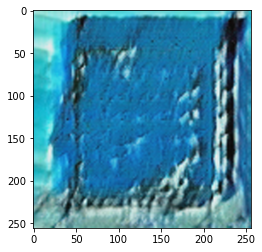

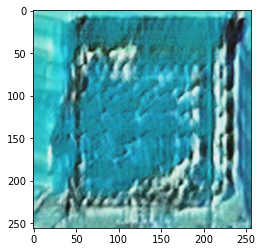

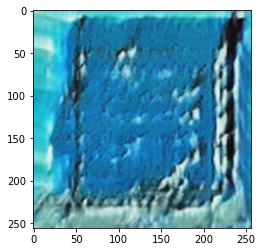

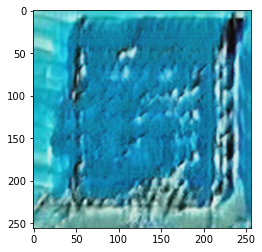

In [3]:
for i in range(images.shape[0]):
    tmp = np.flip(images[i,:,:,:],2)
    tmp = (tmp-np.min(tmp))/(np.max(tmp)-np.min(tmp))
    plt.imshow(tmp)
    plt.show()

## Images Directly from Sentence Embeddings Look Wired

As shown above, we used the first 480 elements of the (512,) embedding as (4,120) input, and the results look quite the same. We can use another random matrix to map the sentence embedding.

(2, 120)
dict_keys(['upsampled', 'default'])


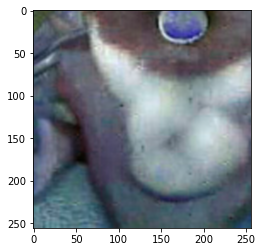

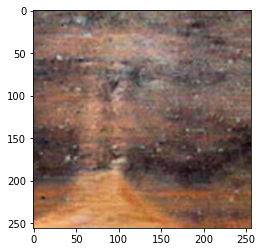

In [11]:
proj = np.random.normal(size=(256,120))
se8 = np.array(se).reshape((2,256))
z = tf.convert_to_tensor(np.matmul(se8, proj), dtype=float)
print(z.shape)

gen_samples = model.signatures['generate'](z)
print(gen_samples.keys())

images = np.array(gen_samples['upsampled'])
for i in range(images.shape[0]):
    tmp = np.flip(images[i,:,:,:],2)
    tmp = (tmp-np.min(tmp))/(np.max(tmp)-np.min(tmp))
    plt.imshow(tmp)
    plt.show()